# Seminario DICOM RT
-----------
Utilizamos los datos sintéticos recién creados para explorar las características de diferentes tipos de archivos.

Instalamos y cargamos el módulo `pydicom`.

In [ ]:
!pip install pydicom

In [1]:
import pydicom as dcm

Cambiamos al directorio donde hayamos subido los datos sintéticos

In [2]:
%cd 'Ruta al directorio de Drive donde hayamos subido los datos sintéticos'

/Users/cesar/Documents/Development/opentps/testData/cuba


## Archivos de imagen
- Para explorar el contenido de los archivos de imagen cargamos cualquiera de los archivos cuyo nombre comiemza por `image`.
    - Listamos el contenido del directorio mediante `%ls`
    - Copiamos el nombre de uno de los archivos
    - Leemmos el contenido medinte `dcm.dcmread('nombreArchivo')` directamente o recogiendo el resultado sobre una variable `imgds`

In [8]:
imgds = dcm.dcmread('image0041_1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.301060.dcm')

Los objetos creados por el módulo `pydicom` contienen propiedades y métodos propias de las funcionalidades del protocolo DICOM.

Para explorarlas en detalle consultar la documentación del módulo.

Algunas propiedades son propias del estudio y de la serie DICOM:
- Study y Series Instance UID
- Study ID
- Series Number
- Instance Number
- Fecha hora del estudio

Otras propiedades son propias del paciente
- Datos demográficos del paciente
- Posición del paciente

Otras son propias de los datos de la imagen
- Filas, columnas
- Frecuencia espacial
- Orientación de las imágenes respecto al paciente
- Localización espacial de las imágemes
- Datos de imagen

Si escribimos la variable y un punto los editores nos ofrecen una lista de todas las propiedades y métodos.

Por ejemplo modificar el siguiente código para explorar los valores de las propiedades relacionadas con el estudio y la serie a la que pertenece la imagen DICOM que hemos leído.

In [9]:
imgds.StudyInstanceUID

'1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.300955'

Exploración de demográficos

In [43]:
print(f'ID: {imgds.PatientID}, Apellido^Nombre: {imgds.PatientName}')

ID: TestDICOM01, Apellido^Nombre: CUBA^MANIQUI


En el archivo DICOM Los datos de la imagen están almacenados en la propiedad `PixelData` pero están códificados en binario. Decodificarlos no es trivial, para hacerlo es necesario de forma *cuidadosa* combinar varias propiedades especificadas en el propio archivo. `pydicom` permite el acceso a los datos sin codificar mediante la propiedad `pixel_array`, que es un array de `numpy`, con todos sus métodos. 

In [10]:
print(f'Rango de los datos: {imgds.pixel_array.shape}, filas: {imgds.Rows}, columnas: {imgds.Columns}')

Rango de los datos: (110, 110), filas: 110, columnas: 110


In [11]:
len(imgds.PixelData), type(imgds.PixelData)

(24200, bytes)

In [14]:
imgds.BitsStored

16

Se utilizan dos bytes para reperesentar cada pixel.

In [12]:
2*imgds.Rows*imgds.Columns

24200

Podemos visualizar la imagen mediaante `matplotlib`

In [15]:
import matplotlib.pyplot as plt

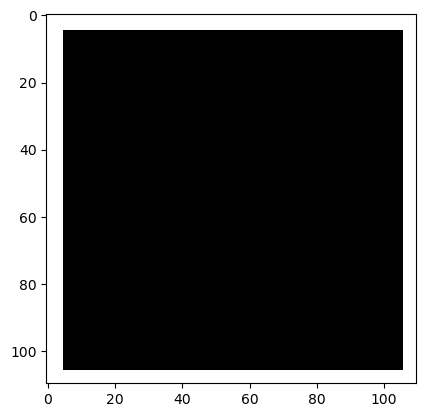

In [16]:
plt.imshow(imgds.pixel_array, cmap=plt.cm.gray_r)

Y también cuantificar los datos de imagen mediante un perfil

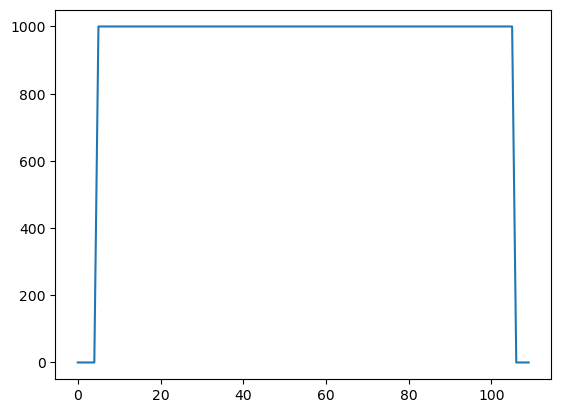

In [17]:
plt.plot(imgds.pixel_array[55,:])

Si nos fijamos en este perfil y en la instrucción `plastimatch` que utilizamos para crear la imagen, observamos que los datos no coinciden. Los datos se almacenan con una transformación lineal. Para recuperar los datos reales tenemos que hacer 

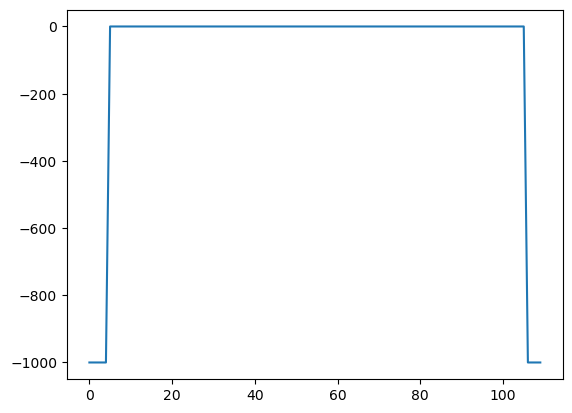

In [18]:
plt.plot(imgds.RescaleSlope * imgds.pixel_array[55,:] + imgds.RescaleIntercept)

Ahora sí hemos obtenido un perfil de agua, numero Hounsfield HU = 0, en el seno de aire (HU=-1000).

Por la manera en la que hemos construido la figura, en el eje x tenemos píxeles. Para tener distancia tenemos que multiplicar el eje por el tamaño de pixel según el eje en el que estemos.

In [19]:
imgds.PixelSpacing

[1.000000, 1.000000]

En este caso la representación coincide. De acuerdo a la especificación DICOM `PixelSpacing` se da en milímetros.

Comprobamos ahora la extensión de la cuba en el eje z. Rastreamos todos los cortes y extraemos la posición de aquellos corte que tiene contenido distinto a aire en el centro

In [20]:
from glob import glob
import numpy as np

In [21]:
img_files = glob('image*')
posiciones_cortes = []
for img_file in img_files:
    img_ds = dcm.dcmread(img_file)
    if img_ds.pixel_array[55, 55] == 1000:
        posiciones_cortes.append(img_ds.SliceLocation)
posiciones_cortes=np.array(posiciones_cortes, np.float32)
posiciones_cortes.sort()
largo_cuba = posiciones_cortes.max() - posiciones_cortes.min()
print(f'Largo de la cuba: {largo_cuba} mm')

Largo de la cuba: 100.0 mm


## Estructuras RT

Para definir y evaluar los tratamientos de radioterapia sobre los archivos de imagen se definen los contornos de las estructuras relevantes, sean volúmenes objetivo, órganos de riesgo o volúmenes de interés.

### Consistencia de las estructuras con el estudio de imagen
Las estructuras se asocian al estudio de imagen mediante una serie de campos.

Leemos el archivo de estructuras

In [22]:
ssds = dcm.dcmread('rtss_1.2.826.0.1.3680043.8.274.1.1.481037312.2245.1734464459.621950.dcm')

Los datos se almacenan en una serie de secuencias anidadas. Identificamenos algunas de ellas

In [23]:
ss_seq = ssds.ReferencedFrameOfReferenceSequence[0]
ref_study_seq = ss_seq.RTReferencedStudySequence[0]
ref_series_seq = ref_study_seq.RTReferencedSeriesSequence[0]
contour_image_seq = ref_series_seq.ContourImageSequence


Comprobamos que los identificadores coinciden en los archivos de imagen y en el archivo de estructuras

In [24]:
import json

In [30]:
ss_ids = {
    'StudyInstanceUID':
        [imgds.StudyInstanceUID, ssds.StudyInstanceUID],
    'SeriesInstanceUID':
        [imgds.SeriesInstanceUID, ref_series_seq.SeriesInstanceUID],
    'FrameOfReferenceUID':
        [imgds.FrameOfReferenceUID, ss_seq.FrameOfReferenceUID],
    'ReferencedSOPInstanceUID':
        [imgds.SOPInstanceUID, contour_image_seq[41].ReferencedSOPInstanceUID]
}

json_ss_ids = json.dumps(ss_ids, indent=2)
print(json_ss_ids)

{
  "StudyInstanceUID": [
    "1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.300955",
    "1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.300955"
  ],
  "SeriesInstanceUID": [
    "1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.300975",
    "1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.300975"
  ],
  "FrameOfReferenceUID": [
    "1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.300956",
    "1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.300956"
  ],
  "ReferencedSOPInstanceUID": [
    "1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.301060",
    "1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.301060"
  ]
}


El último identificador lo dejamos con el *número mágico* en el índice porque para que coincida el identificador, el índice tiene que ser el de la imagen a la que pertecen los contornos.

Este número depende del archivo de imagen seleccionado al leer `imgds`

### Descripción de los contornos

Cada `ContourImageSequence` contiene una secuencia de coordenadas $(x, y, z)$. Las coordenadas $x$ e $y$ describen el contorno correspondiente a la imagen asociada y la $z$ coincide con la posición del corte de esa imagen. 

Las siguientes dos figuras nos muestran el contenido de los dos contornos definidos


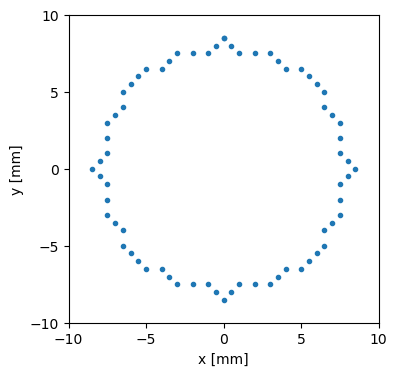

In [31]:
contour0 = np.array(ssds.ROIContourSequence[0].ContourSequence[4].ContourData) # PTV
fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])
ax.set_yticks(np.arange(-10, 11, 5))
ax.plot(contour0[::3], contour0[1::3], '.')
plt.show()

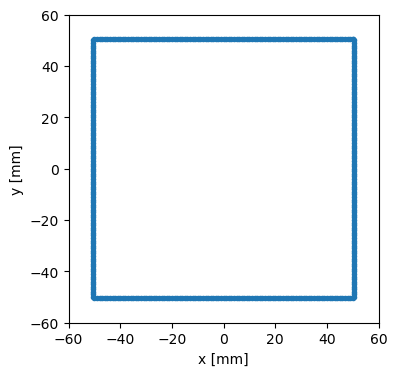

In [32]:
contour1 = np.array(ssds.ROIContourSequence[1].ContourSequence[4].ContourData) # BODY
fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_xlim([-60,60])
ax.set_ylim([-60,60])
ax.set_yticks(np.arange(-60, 61, 20))
ax.plot(contour1[::3], contour1[1::3], '.')
plt.show()

Mediante este código podemos inspeccionar el contenido numéricos de la secuencia de coordenadas

In [33]:
contour0[:99]

array([ 0. ,  8.5, -6. , -0.5,  8. , -6. , -1. ,  7.5, -6. , -2. ,  7.5,
       -6. , -3. ,  7.5, -6. , -3.5,  7. , -6. , -4. ,  6.5, -6. , -5. ,
        6.5, -6. , -5.5,  6. , -6. , -6. ,  5.5, -6. , -6.5,  5. , -6. ,
       -6.5,  4. , -6. , -7. ,  3.5, -6. , -7.5,  3. , -6. , -7.5,  2. ,
       -6. , -7.5,  1. , -6. , -8. ,  0.5, -6. , -8.5,  0. , -6. , -8. ,
       -0.5, -6. , -7.5, -1. , -6. , -7.5, -2. , -6. , -7.5, -3. , -6. ,
       -7. , -3.5, -6. , -6.5, -4. , -6. , -6.5, -5. , -6. , -6. , -5.5,
       -6. , -5.5, -6. , -6. , -5. , -6.5, -6. , -4. , -6.5, -6. , -3.5,
       -7. , -6. , -3. , -7.5, -6. , -2. , -7.5, -6. , -1. , -7.5, -6. ])

Comprobamos que la posición espacial es coherente con el corte de image asociado mediante el `SOPInstanceUID`

In [34]:
mySOPInstanceUID = ssds.ROIContourSequence[0].ContourSequence[4].ContourImageSequence[0].ReferencedSOPInstanceUID
mySOPInstanceUID

'1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.301076'

In [35]:
img_files = glob('image*.dcm')
for img_file in img_files:
    img_ds = dcm.dcmread(img_file)
    if img_ds.SOPInstanceUID == mySOPInstanceUID:
        print(img_ds.SliceLocation)

-6.000000


Valor que como esperábamos coincide con las coordendas $z$ en la secuencia del contorno.

## Dosis

La dosis en DICOM RT se puede considerar como una imagen tridimensional.

Leemos el archivo de dosis

In [36]:
doseds = dcm.dcmread('dose0.dcm')

La dosis se asocia al estudio de imagen mediante una serie de identificadores

In [37]:
dose_ids = {
    'StudyInstanceUID':
        [imgds.StudyInstanceUID, doseds.StudyInstanceUID],
    'SeriesInstanceUID':
        [imgds.SeriesInstanceUID, doseds.SeriesInstanceUID],
    'ReferencedSOPInstanceUID':
        [imgds.SOPInstanceUID, doseds.ReferencedImageSequence[0].ReferencedSOPInstanceUID]
}

json_dose_ids = json.dumps(dose_ids, indent=2)
print(json_dose_ids)

{
  "StudyInstanceUID": [
    "1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.300955",
    "1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.300955"
  ],
  "SeriesInstanceUID": [
    "1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.300975",
    "1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.300975"
  ],
  "ReferencedSOPInstanceUID": [
    "1.2.826.0.1.3680043.8.274.1.1.481037312.1974.1734464449.301060",
    "1.2.826.0.1.3680043.8.274.1.1.8323329.17895.1724170248.176796"
  ]
}


En este caso los identificadores no coinciden porque el cálculo se ha realizado sobre un CT con unos iddentificadores distintos a los del CT sintético creado en este seminario.

Como la geometría es consistente esto no nos impide cargar la distribución de dosis en el software de visualización.

Esto no sería posible sobre un software clínico. En este caso la distribución de dosis va asociado al estudio de imagen, o si se quiere, al paciente.

Podemos visualizar la distribución de dosis como una imagen, con diferentes cortes

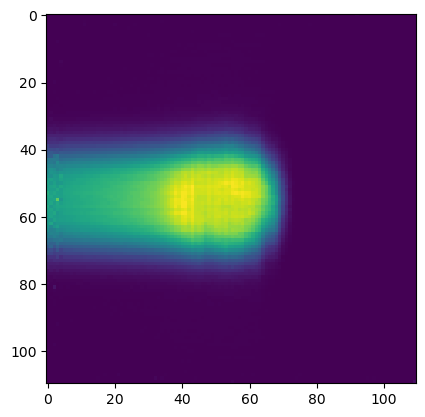

In [38]:
plt.imshow(doseds.pixel_array[..., 50])

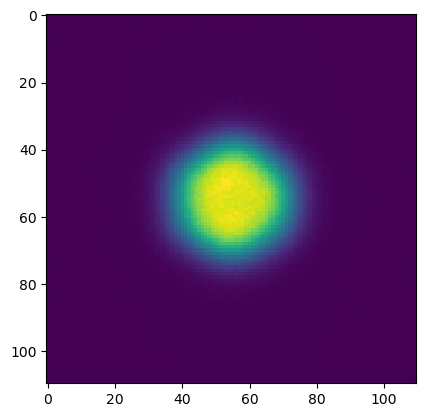

In [39]:
plt.imshow(doseds.pixel_array[:,50,:])

Podemos obtener un perfil y visualizar el pico extendido de Bragg

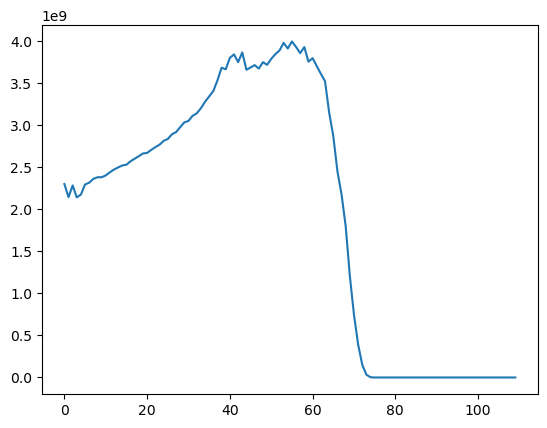

In [40]:
plt.plot(doseds.pixel_array[50,:,50])

Y también obtener detalles geométricos de la distribución como el tamaño de pixel

In [41]:
doseds.PixelSpacing

[1.000000, 1.000000]